In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# get model
model = tf.keras.applications.VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
#model.summary()

553467904/553467096 [==============================] - 3s 0us/step


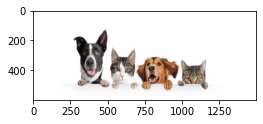

In [18]:
import matplotlib
import matplotlib.pyplot as plt

height = 600
width  = 1500

PATH = '/content/gdrive/My Drive/data/template-matching/'
query = kimage.load_img(PATH+'image7.jpg', target_size=(height, width))

plt.figure(figsize=(4,4))
plt.imshow(query)

In [19]:
# check model
for i in range(19,23):
  print(model.layers[i].name)

flatten
fc1
fc2
predictions


In [20]:
def compute_features(data):
  for i in range(1,19):
    data = model.layers[i](data)
  return data

In [21]:
def compute_prediction(data):
  for i in range(19,23):
    data = model.layers[i](data)
  return data

In [22]:
# compute features
query_np = kimage.img_to_array(query)
query_np = np.expand_dims(query_np, axis=0)
query_np = preprocess_input(query_np)

pred_query = compute_features(query_np)
print(pred_query.shape)

(1, 18, 46, 512)


In [23]:
# compute predictions
height_fm = pred_query.shape[1]
width_fm  = pred_query.shape[2]
depth_fm  = pred_query.shape[3]

side = 7
prediction_data = []
for i in range(height_fm-side+1):
  for j in range(width_fm-side+1):
    patch = pred_query[:,i:i+side,j:j+side,:]
    patch = compute_prediction(patch)
    prediction_data.append( (tf.math.reduce_max(patch[0]).numpy(), 
                             i, j, tf.math.argmax(patch[0]).numpy()) )

In [24]:
def getKey(item):
    return item[0]

tp_sorted = sorted(prediction_data, key=getKey, reverse=True)
print(tp_sorted[:3])

[(0.80608755, 11, 22, 207), (0.80576426, 11, 21, 207), (0.76992136, 6, 10, 227)]


In [25]:
labels = np.load(PATH+'imagenet1000_clsid_to_human.pkl', allow_pickle=True)
print(type(labels))
print(labels[227])

<class 'dict'>
kelpie


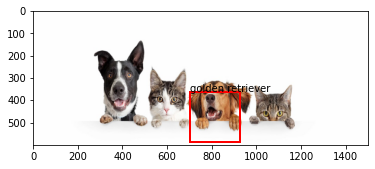

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(PATH+'image7.jpg', target_size=(600, 1500))

fig, ax = plt.subplots()
ax.imshow(im)

# Create a Rectangle patch
scale_height = height//pred_query.shape[1]
scale_width  = width//pred_query.shape[2]
for i in range(1): 
  rect = patches.Rectangle((tp_sorted[i][2]*scale_width,tp_sorted[i][1]*scale_height), 
                           224, 224, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.text(tp_sorted[i][2]*scale_width, tp_sorted[i][1]*scale_height, labels[tp_sorted[i][3]])

plt.show()